In [ ]:


import pandas as pd

combined_df = pd.read_csv("Reviews.csv", usecols=["Score", "Summary", "Text"])

print("First 5 rows of combined_df:")
display(combined_df.head())

First 5 rows of combined_df:


,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Combine 'Summary' and 'Text' into a single 'Review' column
# This provides more context by including both the summary and full text
combined_df['Review'] = combined_df['Summary'] + ' ' + combined_df['Text']

print("\nFirst 3 rows with the new 'Review' column:")
display(combined_df[['Summary', 'Text', 'Review']].head())

# Show the shape of the dataframe to confirm the new column was added
print(f"\nDataFrame shape after adding 'Review' column: {combined_df.shape}")


First 3 rows with the new 'Review' column:


,Summary,Text,Review
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...
2,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha..."
3,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...
4,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...



DataFrame shape after adding 'Review' column: (568454, 4)


In [ ]:
# Drop the specified columns
combined_df = combined_df.drop(columns=['Text', 'Summary'])

# Verify the columns were dropped
print(f"Remaining columns: {combined_df.columns.tolist()}")
print(f"Number of columns after dropping: {len(combined_df.columns)}")

# Display the first few rows to confirm
print("\nFirst 5 rows after dropping columns:")
display(combined_df.head())

Remaining columns: ['Score', 'Review']
Number of columns after dropping: 2

First 5 rows after dropping columns:


,Score,Review
0,5,Good Quality Dog Food I have bought several of...
1,1,Not as Advertised Product arrived labeled as J...
2,4,"""Delight"" says it all This is a confection tha..."
3,2,Cough Medicine If you are looking for the secr...
4,5,Great taffy Great taffy at a great price. The...


In [ ]:
# Map numerical scores to sentiment labels
# 1-2: Negative, 3: Neutral, 4-5: Positive
combined_df['Sentiment'] = combined_df['Score'].apply(
    lambda x: 'Negative' if x <= 2 else 'Neutral' if x == 3 else 'Positive'
)

# Display value counts to verify the distribution
print("\nSentiment Distribution:")
print(combined_df['Sentiment'].value_counts())

# Show a sample of the mapping
print("\nSample of Score to Sentiment mapping:")
display(
    combined_df[['Score', 'Sentiment']]
    .sample(10)
    .sort_values('Score')
)



Sentiment Distribution:
Sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64

Sample of Score to Sentiment mapping:


,Score,Sentiment
447073,3,Neutral
143902,4,Positive
36546,4,Positive
190014,5,Positive
528473,5,Positive
439550,5,Positive
255345,5,Positive
311009,5,Positive
467282,5,Positive
19457,5,Positive


In [ ]:

import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()  # Set to evaluation mode

def get_bert_embeddings(texts, batch_size=32, max_length=128):
    """
    Convert text to BERT embeddings
    """
    embeddings = []

    # Process in batches to avoid memory issues
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing BERT embeddings"):
        batch_texts = texts[i:i+batch_size]

        # Tokenize the text
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        # Get BERT embeddings
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # Use the [CLS] token embedding (first token) as sentence representation
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Prepare your data
# Make sure you have 'Review' and 'Sentiment' columns in your DataFrame
texts = combined_df['Review'].astype(str).tolist()  # Convert to string and list
sentiments = combined_df['Sentiment']

print(f"Processing {len(texts)} reviews...")

# Get BERT embeddings
X_bert = get_bert_embeddings(texts, batch_size=16, max_length=128)
y = sentiments.values

print(f"BERT embeddings shape: {X_bert.shape}")
print(f"Embedding dimension: {X_bert.shape[1]}")

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y, test_size=0.2, random_state=8, stratify=y
)

# Display the shape of the training and testing sets
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")

# Show the distribution of classes in train and test sets
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

# Save the embeddings for future use (optional)
import pickle
with open('bert_embeddings.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'tokenizer': tokenizer
    }, f)
print("\nBERT embeddings saved to 'bert_embeddings.pkl'")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing 568454 reviews...


Processing BERT embeddings:   2%|▏         | 854/35529 [01:43<1:09:55,  8.27it/s]


KeyboardInterrupt: 


Initializing RandomForestClassifier...
Loading BERT embeddings from 'bert_embeddings.pkl'...
BERT embeddings loaded.
Training RandomForestClassifier model...
RandomForestClassifier model training completed!

=== RandomForestClassifier Model Evaluation ===
Accuracy: 0.8480

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.42      0.57      4029
     Neutral       0.94      0.21      0.35      2155
    Positive       0.84      0.99      0.91     21305

    accuracy                           0.85     27489
   macro avg       0.89      0.54      0.61     27489
weighted avg       0.86      0.85      0.82     27489


Confusion Matrix:
[[ 1681    10  2338]
 [  101   457  1597]
 [  114    18 21173]]


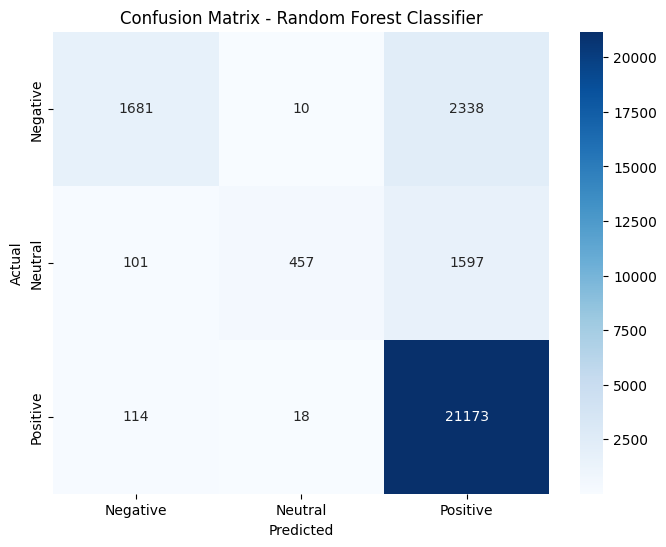


Random Forest model saved as 'sentiment_model_random_forest.pkl'


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize and train the RandomForestClassifier model
print("\nInitializing RandomForestClassifier...")
random_forest_model = RandomForestClassifier(
    random_state=8,
    n_jobs=-1,          # Use all available CPU cores
    max_depth=20,       # Set a suitable max_depth to manage complexity and training time
    class_weight='balanced' # Handles class imbalance
)

# Load the BERT embeddings and split data
print("Loading BERT embeddings from 'bert_embeddings.pkl'...")
with open('bert_embeddings.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
print("BERT embeddings loaded.")



print("Training RandomForestClassifier model...")
random_forest_model.fit(X_train, y_train)
print("RandomForestClassifier model training completed!")

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("\n=== RandomForestClassifier Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the trained model
joblib.dump(random_forest_model, 'sentiment_model_random_forest.pkl')
print("\nRandom Forest model saved as 'sentiment_model_random_forest.pkl'")

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score
import numpy as np
import pickle

# Combine data
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

# Stratified K-Fold
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=8
)

print("Running Stratified K-Fold using cross_val_predict...")

# Cross-validated predictions
y_pred_cv = cross_val_predict(
    random_forest_model,
    X,
    y,
    cv=skf,
    n_jobs=-1
)

# Compute F1 scores manually (SAFE)
f1_macro = f1_score(y, y_pred_cv, average="macro", zero_division=0)
f1_weighted = f1_score(y, y_pred_cv, average="weighted", zero_division=0)

print("\n=== K-Fold Cross-Validation Results ===")
print(f"F1-Macro    : {f1_macro:.4f}")
print(f"F1-Weighted : {f1_weighted:.4f}")


Running Stratified K-Fold using cross_val_predict...

=== K-Fold Cross-Validation Results ===
F1-Macro    : 0.5964
F1-Weighted : 0.8128


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pickle
from sklearn.metrics import classification_report # Added for classification report
import joblib # Import joblib for saving the model

# Load the BERT embeddings and split data
print("Loading BERT embeddings from 'bert_embeddings.pkl'...")
with open('bert_embeddings.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
print("BERT embeddings loaded.")

# Convert labels to categorical if needed
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Build neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print("Training Neural Network on BERT embeddings...")
history = model.fit(
    X_train, y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"\nNeural Network Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert back to original labels
y_pred_original = le.inverse_transform(y_pred)

print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_original))


# Save the trained model
joblib.dump(model, 'sentiment_model_NN.pkl')
print("\nNN classifer model saved as 'sentiment_model_NN.pkl'")

Loading BERT embeddings from 'bert_embeddings.pkl'...
BERT embeddings loaded.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Neural Network on BERT embeddings...
Epoch 1/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8151 - loss: 0.4997 - val_accuracy: 0.8472 - val_loss: 0.4016
Epoch 2/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8399 - loss: 0.4146 - val_accuracy: 0.8494 - val_loss: 0.3914
Epoch 3/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8441 - loss: 0.4056 - val_accuracy: 0.8456 - val_loss: 0.4099
Epoch 4/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8454 - loss: 0.4026 - val_accuracy: 0.8554 - val_loss: 0.3785
Epoch 5/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8470 - loss: 0.3958 - val_accuracy: 0.8536 - val_loss: 0.3758
Epoch 6/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8498 - loss: 0.3865 - val_accuracy: 0.8579 - val_loss: 0.3741
Epoch 7/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8489 - loss: 0.3891 - val_accuracy: 0.8538 - val_loss: 0.3761
Epoch 8/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 

[[ 2955   129   945]
 [  640   294  1221]
 [  662   167 20476]]


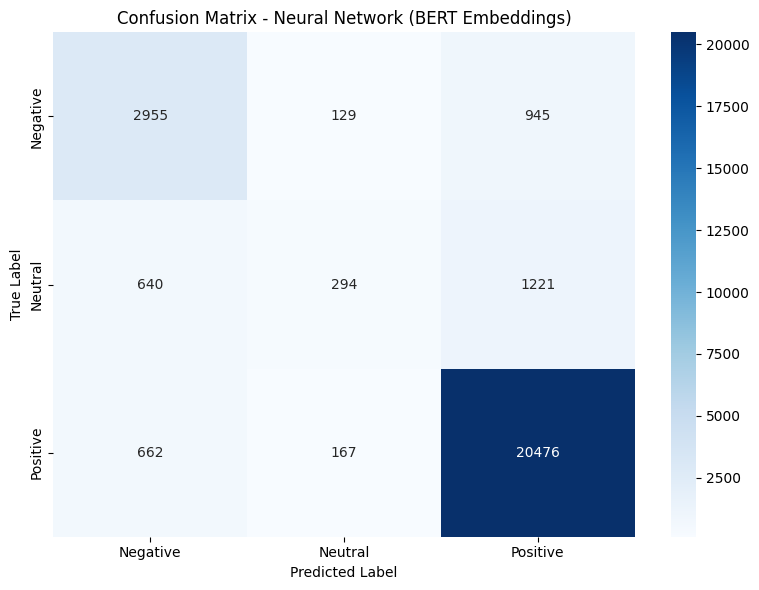

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_original)
print(cm)
# Get class labels (original sentiment names)
class_labels = le.classes_

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.title("Confusion Matrix - Neural Network (BERT Embeddings)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
import pickle
import joblib
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# =========================
# Load BERT embeddings
# =========================
with open("bert_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
X_test  = data["X_test"]
y_train = data["y_train"]
y_test  = data["y_test"]

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# =========================
# Encode string labels
# =========================
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

print("\nClass mapping:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"{i} → {cls}")

num_classes = len(label_encoder.classes_)

# =========================
# XGBoost Multi-class Model
# =========================
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)

xgb_model.fit(X_train, y_train_enc)

# =========================
# Evaluation
# =========================
y_pred_enc = xgb_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test_enc, y_pred_enc))

print("\nClassification Report:")
print(
    classification_report(
        y_test_enc,
        y_pred_enc,
        target_names=label_encoder.classes_
    )
)

print("\nConfusion Matrix:")
cm_xg = confusion_matrix(y_test_enc, y_pred_enc)
print(cm_xg)
# =========================
# Save model & encoder
# =========================
joblib.dump(xgb_model, "xgboost_bert_multiclass.pkl")
joblib.dump(label_encoder, "sentiment_label_encoder.pkl")

print("\nModel saved as xgboost_bert_multiclass.pkl")
print("Label encoder saved as sentiment_label_encoder.pkl")


Train shape: (109955, 768)
Test shape : (27489, 768)

Class mapping:
0 → Negative
1 → Neutral
2 → Positive

Accuracy: 0.8728946123904107

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.68      0.72      4029
     Neutral       0.70      0.25      0.36      2155
    Positive       0.90      0.97      0.93     21305

    accuracy                           0.87     27489
   macro avg       0.78      0.63      0.67     27489
weighted avg       0.86      0.87      0.86     27489


Confusion Matrix:
[[ 2752   105  1172]
 [  410   528  1217]
 [  468   122 20715]]

Model saved as xgboost_bert_multiclass.pkl
Label encoder saved as sentiment_label_encoder.pkl


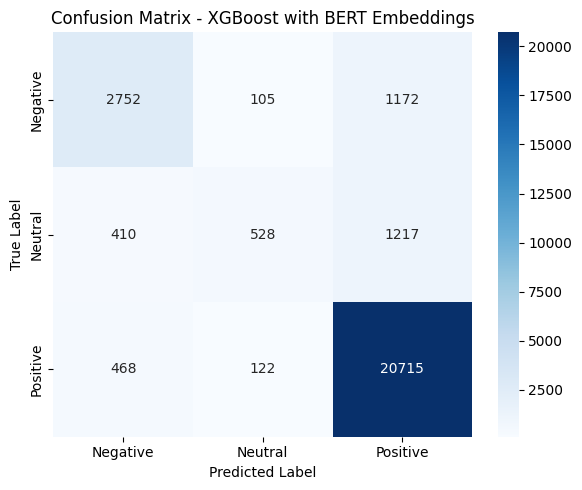

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Class labels
class_names = label_encoder.classes_

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_xg,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost with BERT Embeddings")
plt.tight_layout()
plt.show()
